# ESCUELA POLITÉCNICA NACIONAL
# FACULTAD DE INGENIERÍA EN SISTEMAS

## Proyecto Bimestral: Sistema de Recuperación de Información basado en Imágenes

### Autor: Soto Condoy Bruce Andrés

## 1. INTRODUCIÓN

El objetivo principal de este proyecto es crear un buscador innovador que permita a los usuarios hacer preguntas usando imágenes en vez de palabras. Este sistema estará diseñado para encontrar imágenes similares dentro de una colección específica de imágenes. El proyecto se dividirá en varias etapas, las cuales se detallarán a continuación.


## 2. FASES DEL PROYECTO
Para realizar el proyecto se ocuparon libreías, las cuales seran de mucha ayuda al momento de realizar cada una de las fases del proyecto. Antes de continuar se muestran cada una de ellas y su respectiva función

#### Importación de librerías


In [1]:
import tensorflow as tf
from keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from tensorflow.keras.preprocessing import image as keras_image

###  2.1. Adquisición de Datos
Para la realización de este estudio, se empleó el conjunto de datos Caltech101. Este dataset fue obtenido a través de TensorFlow Datasets y ofrece una amplia variedad de 101 categorías de objetos, proporcionando un banco de pruebas robusto para evaluar la capacidad de clasificación de los modelos propuestos. <br> Tras la descarga, se verificó la integridad de los datos y se organizó la estructura de directorios para facilitar su procesamiento posterior.

In [5]:
# cargar el dataset caltech101
(train_dataset, test_dataset), dataset_info = tfds.load(
    name='caltech101',
    split=['train[:80%]', 'test[:20%]'],  #division del dataset: 80% para entrenamiento, 20% para prueba
    with_info=True,
    as_supervised=True,
    data_dir='C:\\Users\\basc6\\PycharmProjects\\proyect-RI_Soto-Bruce\\datosCaltech',
    download=True  # cambiar a true para descargar el dataset si no esta disponible
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\basc6\PycharmProjects\proyect-RI_Soto-Bruce\datosCaltech\caltech101\incomplete.7EFGSQ_3.0.2…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\basc6\PycharmProjects\proyect-RI_Soto-Bruce\datosCaltech\caltech101\incomplete.7EFGSQ_3.0.2…

Dataset caltech101 downloaded and prepared to C:\Users\basc6\PycharmProjects\proyect-RI_Soto-Bruce\datosCaltech\caltech101\3.0.2. Subsequent calls will reuse this data.


###  2.2. Preprocesamiento

#### Creación de la funcion para preprocesar las imagenes
La variable *tamanio_imagen* establece un tamaño para todas las imagenes que van a ser preprocesadas

In [13]:
tamanio_imagen = 224

La función "preprocess_image" se encarga de preparar las imágenes del dataset Caltech101.
- En primer lugar, redimensiona todas las imágenes a un tamaño estándar de *tamanio_imagen* x *tamanio_imagen* píxeles para garantizar una entrada uniforme a la red.
- Posteriormente, normaliza los valores de los píxeles entre 0 y 1, lo cual es un paso esencial para mejorar la convergencia del entrenamiento y la precisión del modelo.

In [11]:
def preprocess_image(image):
    image = tf.image.resize(image, (tamanio_imagen, tamanio_imagen))  # redimensionar la imagen
    image = tf.cast(image, tf.float32) / 255.0  # normalizar la imagen

    return image

#### Preparación del conjuntos de datos de entrenamiento y prueba
Los conjuntos de datos de entrenamiento y prueba (train_dataset y test_dataset, respectivamente) son preprocesados y preparados para el entrenamiento de la red neuronal.
- Los datos son aleatorizados para evitar sesgos en el entrenamiento, agrupados en lotes de 32 imágenes para mejorar la eficiencia computacional y optimizados utilizando *tf.data.experimental.AUTOTUNE* para acelerar el proceso de entrenamiento.

In [ ]:
train_dataset_preprocessed = (train_dataset
                              .map(preprocess_image)
                              .shuffle(1000)  # aleatorizar el orden de las imagenes
                              .batch(32)  # agrupar en lotes de 32 imagenes
                              .prefetch(tf.data.experimental.AUTOTUNE))  # optimizar el rendimiento
test_dataset_preprocessed = (test_dataset
                             .map(preprocess_image)
                             .batch(32)  # agrupar en lotes de 32 imagenes
                             .prefetch(tf.data.experimental.AUTOTUNE))  # optimizar el rendimiento

###  2.3 Extracción de Características

#### Preparación del modelo
La configuración permite aprovechar el poder discriminatorio de las capas convolucionales del VGG16 para extraer características relevantes de las imágenes, las cuales serán utilizadas posteriormente para realizar tareas de detección de objetos.
- Se carga el modelo preentrenado VGG16, excluyendo la capa de clasificación superior, para utilizarlo como extractor de características.
- Se crea un nuevo modelo que toma como entrada las mismas entradas del VGG16 original pero cuya salida corresponde a los mapas de características de la última capa convolucional.<br>

In [ ]:
# cargar el modelo VGG16 preentrenado, sin la capa de clasificacion superior
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(tamanio_imagen, tamanio_imagen, 3))

# crear un modelo que devuelve los mapas de caracteristicas
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

#### Creación de la función para extraer de características
La función "extract_features" procesa el dataset, extrayendo características utilizando el modelo VGG16 preentrenado. Estas características son almacenadas junto con las imágenes originales y sus etiquetas correspondientes.<br>
Aplicamos la técnica de Transfer Learning al utilizar el VGG16 como punto de partida y ajustar sus capas finales a nuestra tarea específica.

In [ ]:
# funcion para extraer caracteristicas usando VGG16
def extract_features(dataset):
    features = []  # lista para almacenar los mapas de caracteristicas
    images = []  # lista para almacenar las imagenes originales
    labels = []  # lista para almacenar las etiquetas

    for img_batch, lbl_batch in dataset:
        feature_maps = model.predict(img_batch)  # obtener mapas de caracteristicas
        features.append(feature_maps)
        images.append(img_batch.numpy())  # almacenar imagenes originales
        labels.append(lbl_batch.numpy())  # almacenar etiquetas
    return np.vstack(features), np.vstack(images), np.hstack(labels)

Posteriormente, las características se aplanan y normalizan para su uso en modelos posteriores.

In [47]:
# extraer caracteristicas para los datasets de entrenamiento y prueba
train_features, train_images, train_labels = extract_features(train_dataset_preprocessed)
# aplanar los mapas de caracteristicas
train_features_flat = train_features.reshape(train_features.shape[0], -1)
# normalizar los mapas de caracteristicas
train_features_flat = normalize(train_features_flat)

# Guardar las características aplanadas en un archivo
np.save('train_features.npy', train_features_flat)
# Guardar las imágenes originales en un archivo
np.save('train_images.npy', train_images)
# Guardar las etiquetas en un archivo
np.save('train_labels.npy', train_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 

#### 2.4. Indexación

#### Creación del índice
Se utiliza el algoritmo de los k vecinos más cercanos para encontrar las imágenes más similares a una consulta dada. Se usa *train_features_flat* ya que contiene las características extraídas de todas las imágenes del conjunto de entrenamiento, que servirán como puntos de referencia para la búsqueda.

In [14]:
# crear el indice k-NN
knn = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(train_features_flat)

### 2.5 Diseño del Motor de Búsqueda


#### Creación de funciones para la consulta
- La función "load_and_preprocess_image" carga y preprocesa la imagen de consulta.
- La función "extract_features_image" extraer caracteristicas de la imagen de consulta.
- La función "search_similar_images" toma como entrada las características de la imagen de consulta y utiliza el modelo k-NN para encontrar los k vecinos más cercanos en el espacio de características.<br>
- La función "show_neighbors" muestra la imagen de consulta y sus vecinos más cercanos, junto con sus respectivas distancias y etiquetas.

In [40]:
# funcion para cargar y preprocesar una imagen externa
def load_and_preprocess_image(image_path):
    original_image = keras_image.load_img(image_path,
                                          target_size=(tamanio_imagen, tamanio_imagen))  # redimensionar la imagen
    image_array = keras_image.img_to_array(original_image) / 255.0  # normalizar la imagen
    preprocessed_image = np.expand_dims(image_array, axis=0)  # expandir dimensión para el modelo
    return preprocessed_image, image_array


# funcion para extraer caracteristicas de una imagen
def extract_features_image(image, model):
    feature_maps = model.predict(image)  # obtener mapas de caracteristicas del modelo
    features_flattened = feature_maps.flatten()  # aplanar los mapas de caracteristicas
    return normalize([features_flattened])[0]


# funcion para buscar imagenes similares usando k-NN con la misma etiqueta
def search_similar_images(query_feature, train_labels, k=5):
    query_feature_normalized = normalize([query_feature])[0]  # normalizar la caracteristica de consulta
    distances, indices = knn.kneighbors([query_feature_normalized], n_neighbors=len(train_labels))

    # obtener la etiqueta del primer vecino
    target_label = train_labels[indices[0][0]]

    # filtrar por la misma etiqueta
    filtered_indices = []
    filtered_distances = []

    for dist, idx in zip(distances[0], indices[0]):
        if train_labels[idx] == target_label:
            filtered_indices.append(idx)
            filtered_distances.append(dist)
        if len(filtered_indices) == k:  # detener cuando tengamos 5 vecinos con la misma etiqueta
            break

    return filtered_distances, filtered_indices


"""
# funcion para buscar imagenes similares usando k-NN
def search_similar_images(query_feature, k=5):
    query_feature_normalized = normalize([query_feature])[0]  # normalizar la caracteristica de consulta
    distances, indices = knn.kneighbors([query_feature_normalized], n_neighbors=k)  # buscar k vecinos mas cercanos
    return distances[0], indices[0]
"""


# funcion para mostrar la imagen de consulta y sus vecinos mas cercanos
def show_neighbors(query_image, query_label, train_images, train_labels, indices, distances):
    num_neighbors = len(indices)
    plt.figure(figsize=(20, 5))

    # Mostrar la imagen de consulta
    plt.subplot(1, num_neighbors + 1, 1)
    plt.imshow(query_image)
    plt.title(f'Consulta\nEtiqueta: {query_label}')
    plt.axis('off')

    # mostrar las imagenes de los vecinos mas cercanos
    for i, index in enumerate(indices):
        plt.subplot(1, num_neighbors + 1, i + 2)
        neighbor_image = train_images[index]
        neighbor_label = train_labels[index]
        plt.imshow(neighbor_image)
        plt.title(f'Vecino {i + 1}\nEtiqueta: {neighbor_label}\nDist: {distances[i]:.2f}')
        plt.axis('off')

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


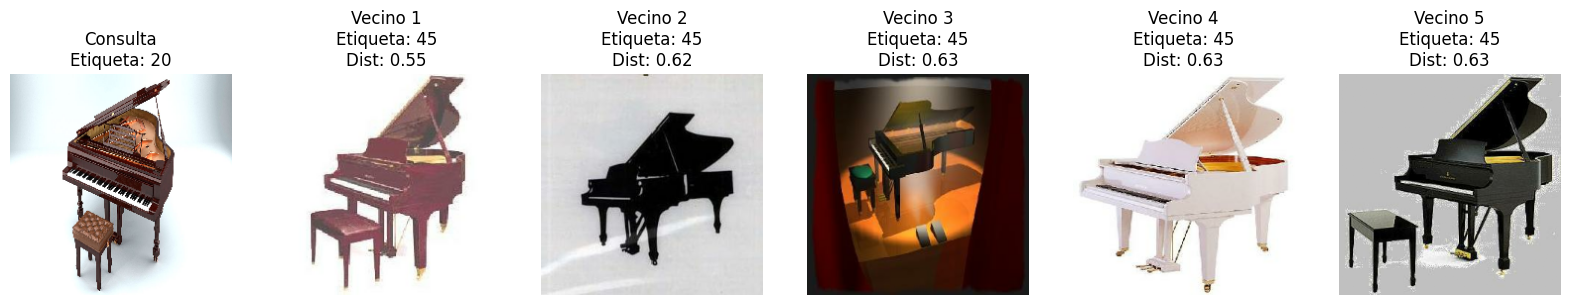

In [45]:
# extraer todas las imagenes y su etiqueta
for images, labels in train_dataset_preprocessed.take(1):
    query_image = images[0].numpy()
    query_label = labels[0].numpy()

image_path = '.venv/imagenes/piano.jpg'  # ruta de la imagen de consulta

query_image_preprocessed, query_image_display = load_and_preprocess_image(
    image_path)  # cargar y preprocesar la imagen de consulta

# extraer caracteristicas de la imagen de consulta
query_features = extract_features_image(query_image_preprocessed, model)

# encontrar los vecinos mas cercanos
distances, indices = search_similar_images(query_features, train_labels, 5)

# mostrar la imagen de consulta y sus vecinos mas cercanos
show_neighbors(query_image_display, query_label, train_images, train_labels, indices, distances)

### 2.6. Evaluación del Sistema

#### Definir un Conjunto de Métricas de Evaluación
Se utilizan las métricas de precisión, recall y F1-score para evaluar el sistema de búsqueda de imágenes. 

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

#### Pruebas utilizando el conjunto de prueba del corpus
La función "evaluate_image_search_system" toma el conjunto de prueba *test_dataset_preprocessed* y lo utiliza para evaluar el sistema de búsqueda. Para cada imagen de prueba, se calculan las características, se buscan imágenes similares y se evalúan las predicciones con respecto a las etiquetas reales usando las métricas definidas.

In [ ]:
# funcion para evaluar el sistema de busqueda de imagenes
def evaluate_image_search_system(test_dataset, model, knn, train_images, train_labels, k=5):
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # iterar sobre el conjunto de prueba
    for images, labels in test_dataset:
        for i in range(len(images)):
            query_image = images[i].numpy()
            query_label = labels[i].numpy()

            # Extraer características de la imagen de consulta
            query_image_tf = tf.expand_dims(tf.convert_to_tensor(query_image), axis=0)
            query_features = model.predict(query_image_tf).flatten()

            # Buscar imágenes similares
            distances, indices = search_similar_images(query_features, train_labels, k=k)

            # Obtener etiquetas de los vecinos más cercanos
            predicted_labels = [train_labels[idx] for idx in indices]

            # Calcular las métricas
            precision = precision_score([query_label] * k, predicted_labels, average='micro', zero_division=1)
            recall = recall_score([query_label] * k, predicted_labels, average='micro', zero_division=1)
            f1 = f1_score([query_label] * k, predicted_labels, average='micro', zero_division=1)

            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)
            #Promedios de las métricas
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)

    return avg_precision, avg_recall, avg_f1


#### Comparación del rendimiento
Aquí se usa el conjunto de prueba preprocesado para evaluar el rendimiento del sistema.

In [46]:
# evaluar el sistema de busqueda de imagenes
avg_precision, avg_recall, avg_f1 = evaluate_image_search_system(
    test_dataset_preprocessed, model, knn, train_images, train_labels, k=5
)

print(f"Precisión promedio: {avg_precision:.4f}")
print(f"Recall promedio: {avg_recall:.4f}")
print(f"F1-score promedio: {avg_f1:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 